In [160]:
# importing required librarys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import datetime


In [161]:
data = pd.read_csv('forecast.csv')

In [162]:
# checking the data
data.head()

,ds,y
0,2018-04-01,1434
1,2018-04-02,4322
2,2018-04-03,4472
3,2018-04-04,4548
4,2018-04-05,4824


In [163]:
data.tail()

,ds,y
912,2020-09-30,13514
913,2020-10-01,13598
914,2020-10-02,13628
915,2020-10-03,5516
916,2020-10-04,4624


In [164]:
# changing the dtype of data column and also setting date column as index
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('forecast.csv', parse_dates=['ds'], index_col='ds',date_parser=dateparse)

<ipython-input-164-8521bdda9b80>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


In [165]:
# checking null values
data.isnull().sum()

y    0
dtype: int64

In [166]:
# checking max,min values
data.max()


y    15351
dtype: int64

In [167]:
data.min()

y    568
dtype: int64

In [168]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 917 entries, 2018-04-01 to 2020-10-04
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       917 non-null    int64
dtypes: int64(1)
memory usage: 14.3 KB


In [169]:
data.columns

Index(['y'], dtype='object')

In [170]:
data.dtypes

y    int64
dtype: object

In [171]:
data.sort_index(inplace=True)

#### selecting the data from 2018-04-01 to  2020-09-13 to train the model

In [250]:
data_train = data['2018-04-01':'2020-09-13']

In [252]:
data_test = data['2020-09-14': '2020-10-04']

<AxesSubplot:xlabel='ds'>

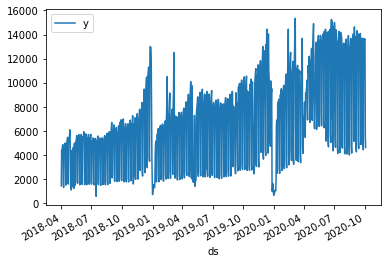

In [172]:
data.plot()

#### Checking Stationarity of a Time Series using Dickey-Fuller Test:

In [173]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(y):
    
    result = adfuller(y)
    
    labels = ['ADF Test Statistics', 'p-value', '#Lags used', 'Number of observations used']
    
    for value,label in zip(result, labels):
       
         print(label+":"+str(value))
    
    if result[1]<= 0.05:
       
         print('strong evidence against the null hypothesis(HO), rejecting the null hypothesis. data is stationary')
   
    else:
        
        print('weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary')
    

In [174]:
adfuller_test(data)

ADF Test Statistics:-2.1301703368362808
p-value:0.23255724864326044
#Lags used:21
Number of observations used:895
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary


##### now data is not stationary so we have to make it stationary 

1.Estimating & Eliminating Trend

simple way to make it stationary is apply log,squre root,cube root

In [175]:
# applying log transformtion on data
data_log = np.log(data)

<AxesSubplot:xlabel='ds'>

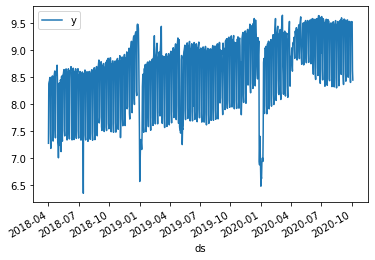

In [176]:
data_log.plot()

In [177]:
# applying squreroot on data
data_sqrt = np.sqrt(data)

<AxesSubplot:xlabel='ds'>

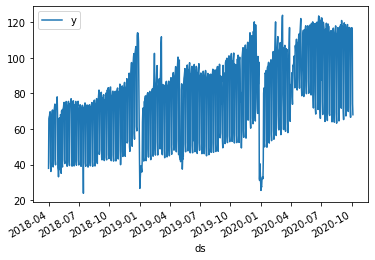

In [179]:
data_sqrt.plot()

In [180]:
# applying cube root on data
data_cube = np.cbrt(data)

<AxesSubplot:xlabel='ds'>

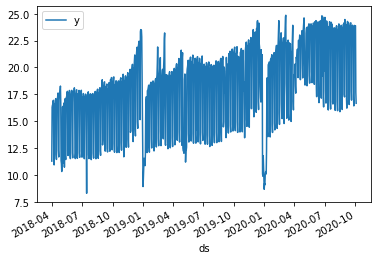

In [181]:
data_cube.plot()

#### from the above by applying log transformation higher values reduced to lower values and again we are applying moving average make data smooth 

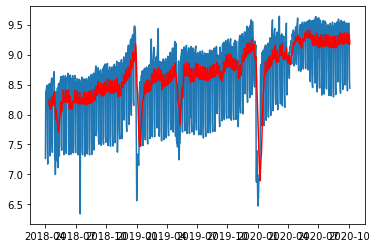

In [182]:
moving_avg = data_log.rolling(12).mean()
plt.plot(data_log)
plt.plot(moving_avg, color='red')

In [183]:
data_log_moving_avg_diff = data_log - moving_avg# we subtracting the moving avg from original data
data_log_moving_avg_diff.head(12)

,y
ds,
2018-04-01,NaN
2018-04-02,NaN
2018-04-03,NaN
2018-04-04,NaN
2018-04-05,NaN
2018-04-06,NaN
2018-04-07,NaN
2018-04-08,NaN
2018-04-09,NaN


In [184]:
# now again we are testing the stationary
adfuller_test(data_log_moving_avg_diff.dropna())

ADF Test Statistics:-8.35545518091491
p-value:2.9174786606229135e-13
#Lags used:21
Number of observations used:884
strong evidence against the null hypothesis(HO), rejecting the null hypothesis. data is stationary


#### now data is stationary

#### Differencing data to check stationary

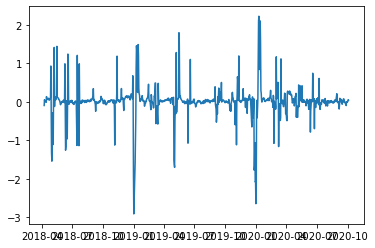

In [185]:
data_log_diff = data_log - data_log.shift(7)#taking 7 days differencing
plt.plot(data_log_diff)

In [186]:
adfuller_test(data_log_diff.dropna())

ADF Test Statistics:-8.523941814481478
p-value:1.0818466856472523e-13
#Lags used:21
Number of observations used:888
strong evidence against the null hypothesis(HO), rejecting the null hypothesis. data is stationary


#### data is stationary

#### applying Decomposing to eliminate seasonality and trends seperatly

<ipython-input-187-06026ab0659a>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(data_log, freq = 52)


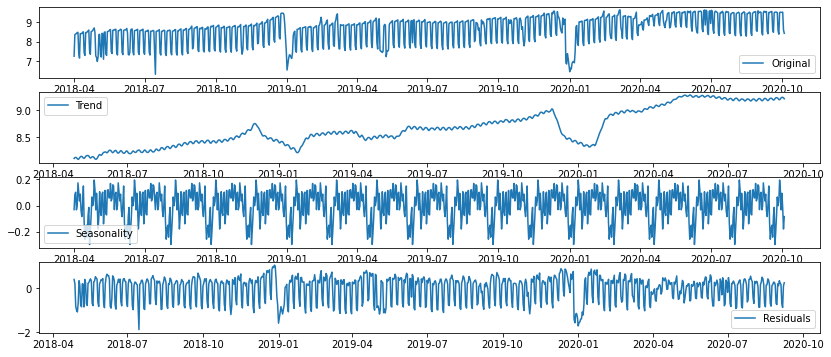

In [187]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_log, freq = 52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig =plt.figure(figsize = (14,6))
plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

In [ ]:
# checking stationarity of residuals

In [188]:
data_log_decompose = residual
data_log_decompose.dropna(inplace=True)
adfuller_test(data_log_decompose)

ADF Test Statistics:-8.4838860280453
p-value:1.36978357206613e-13
#Lags used:21
Number of observations used:843
strong evidence against the null hypothesis(HO), rejecting the null hypothesis. data is stationary


#### Forecasting a Time Series using ARIMA

In [189]:
#ploting ACF and PACF plots

from statsmodels.tsa.stattools import acf, pacf

In [190]:
lag_acf = acf(data_log_diff.dropna(), nlags=20)
lag_pacf = pacf(data_log_diff.dropna(), nlags=20, method='ols')

C:\Users\tharu\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'PartialAutocorrelation Function')

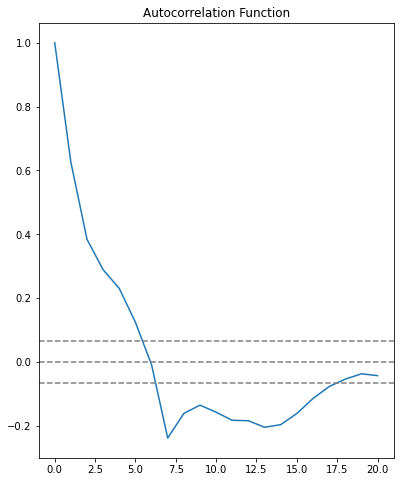

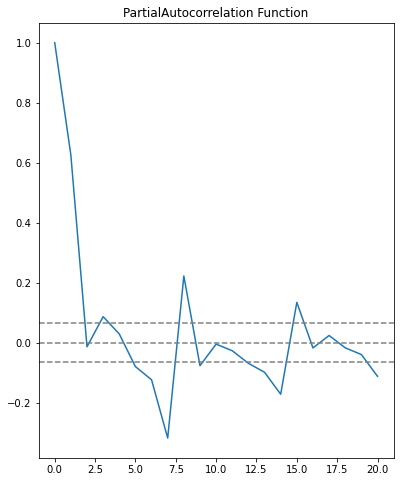

In [191]:
fig = plt.figure(figsize = (14,8))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
fig = plt.figure(figsize = (14,8))
plt.subplot(122) 
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff.dropna())),linestyle='--',color='gray')
plt.title('PartialAutocorrelation Function')

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\tharu\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\tharu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

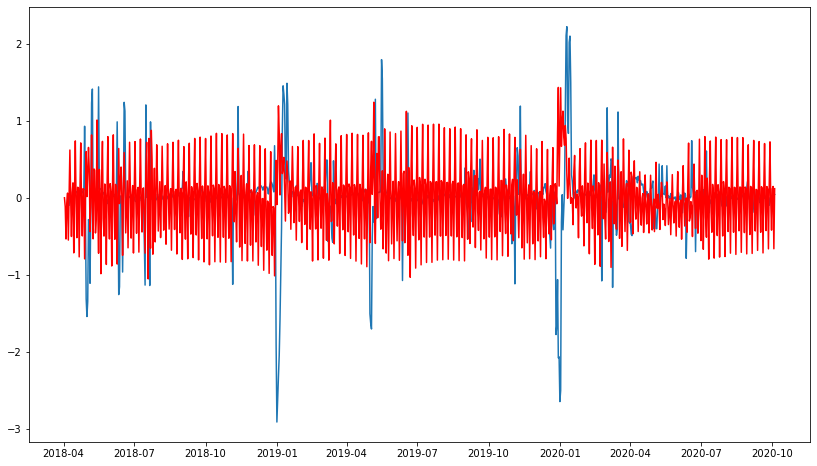

In [192]:
# ARIMA Model
model = ARIMA(data_log, order=(2, 1, 5))  
results_ARIMA = model.fit(disp=-1) 
fig = plt.figure(figsize = (14,8))
plt.plot(data_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.show()

In [264]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

ds
2018-04-02    0.001210
2018-04-03   -0.113240
2018-04-04   -0.534216
2018-04-05   -0.070785
2018-04-06    0.062048
dtype: float64

In [265]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

ds
2018-04-02    0.001210
2018-04-03   -0.112030
2018-04-04   -0.646246
2018-04-05   -0.717030
2018-04-06   -0.654982
dtype: float64

In [266]:
data_log.iloc[0]

y    7.268223
Name: 2018-04-01 00:00:00, dtype: float64

In [267]:
predictions_ARIMA_log = pd.Series(7.268223, index=data_log.index)#adding data_log.iloc[0] value to entire data to get back original values


In [268]:
predictions_ARIMA_log

ds
2018-04-01    7.268223
2018-04-02    7.268223
2018-04-03    7.268223
2018-04-04    7.268223
2018-04-05    7.268223
                ...   
2020-09-30    7.268223
2020-10-01    7.268223
2020-10-02    7.268223
2020-10-03    7.268223
2020-10-04    7.268223
Length: 917, dtype: float64

In [269]:
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

ds
2018-04-01    7.268223
2018-04-02    7.269433
2018-04-03    7.156193
2018-04-04    6.621977
2018-04-05    6.551193
dtype: float64

In [270]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)# applying exponential to getback original values

In [271]:
predictions_ARIMA

ds
2018-04-01    1433.999970
2018-04-02    1435.735946
2018-04-03    1282.020906
2018-04-04     751.429490
2018-04-05     700.078646
                 ...     
2020-09-30     940.749226
2020-10-01    1058.142841
2020-10-02    1227.385863
2020-10-03     633.732927
2020-10-04     714.217573
Length: 917, dtype: float64

In [272]:
predictions_ARIMA.tail(21)#2020-09-14 till 2020-10-04,

ds
2020-09-14    1800.210018
2020-09-15    1677.952753
2020-09-16    1072.892524
2020-09-17    1241.085986
2020-09-18    1404.522720
2020-09-19     686.852316
2020-09-20     782.778079
2020-09-21    1585.048845
2020-09-22    1428.346426
2020-09-23     933.487927
2020-09-24    1081.045462
2020-09-25    1210.444554
2020-09-26     624.189969
2020-09-27     726.140065
2020-09-28    1502.941267
2020-09-29    1430.259358
2020-09-30     940.749226
2020-10-01    1058.142841
2020-10-02    1227.385863
2020-10-03     633.732927
2020-10-04     714.217573
dtype: float64

In [273]:
data_predicted = predictions_ARIMA.tail(21)

In [275]:
data_predicted= pd.Series(data_predicted)

In [281]:
data_predicted= data_predicted.to_frame('forecast_values')

#### predicted values from 2020-09-14 to 2020-10-04 using ARIMA model

In [311]:
data_predicted

,forecast_values
ds,
2020-09-14,1800.210018
2020-09-15,1677.952753
2020-09-16,1072.892524
2020-09-17,1241.085986
2020-09-18,1404.522720
2020-09-19,686.852316
2020-09-20,782.778079
2020-09-21,1585.048845
2020-09-22,1428.346426
